In [281]:
import pandas as pd
import numpy as np

In [282]:
europe_or_nearby = ['Austria', 'Belarus', 'Belgium', 'Bulgaria', 'Croatia', 'Czechia',
       'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece',
       'Hungary', 'Ireland', 'Italy', 'Luxembourg', 'Netherlands',
       'North Macedonia', 'Norway', 'Poland', 'Portugal', 'Romania',
       'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland',
       'United Kingdom']

In [283]:
distance = pd.read_csv('data/controls/distance.csv', index_col=0)
subsidies = pd.read_csv('data/controls/energy_subsidies.csv', index_col=0)
urss = pd.read_csv('data/controls/ex_urss_influenced.csv', index_col=0)
gdppc = pd.read_csv('data/controls/GDPperCap.csv', index_col=0)
unemployment = pd.read_csv('data/controls/unemployment.csv', index_col=0)

In [284]:
# keep change in subsidies from 2021 to 2022
subsidies['increase'] = subsidies['2022'] - subsidies['2021']
subsidies = subsidies[['increase']].rename(columns={'increase': 'energy_subsidies_increase'})

In [285]:
# will talke 2022 (not the change), to account for country economic disparities

# keep only countries in Europe or nearby for gdppc
gdppc = gdppc.loc[gdppc.index.isin(europe_or_nearby)]
gdppc = gdppc[['2022']].rename(columns={'2022': 'gdppc'})

In [286]:
unemployment = unemployment.loc[unemployment.index.isin(europe_or_nearby)]
unemployment['increase'] = unemployment['2022'] - unemployment['2021']
unemployment = unemployment[['2022']].rename(columns={'2022': 'unemployment_increase'})

In [287]:
bartik = pd.read_csv('data/FINAL_BARTIK.csv', index_col=0)

In [288]:
approvals = pd.read_csv('../Design/data/Approvals_cleaned.csv')
approvals.drop(columns=['Sweden', 'Italy'], inplace=True)

def compute_approval_change(start_date, end_date):
    df = approvals.copy()
    df['Date'] = pd.to_datetime(df['Date'])  # ensure datetime format

    # Convert wide to long format
    df_long = df.melt(id_vars='Date', var_name='country', value_name='approval')

    # Filter date range
    df_long = df_long[(df_long['Date'] >= start_date) & (df_long['Date'] <= end_date)]

    # Calculate change from start to end per country
    start_approvals = df_long[df_long['Date'] == pd.to_datetime(start_date)]
    end_approvals = df_long[df_long['Date'] == pd.to_datetime(end_date)]

    merged = pd.merge(start_approvals, end_approvals, on='country', suffixes=('_start', '_end'))
    merged['approval_change'] = merged['approval_end'] - merged['approval_start']

    return merged[['country', 'approval_change']]

approval_change = compute_approval_change('2022-06-01', '2022-12-01').dropna()

In [289]:
approval_change.index = approval_change['country']
approval_change = approval_change[['approval_change']]

### Merge all together

In [290]:
# merge all controls into one DataFrame
dataset = distance.join(subsidies).join(urss).join(gdppc).join(unemployment).join(bartik).join(approval_change)

In [291]:
dataset.dropna(inplace=True)

In [292]:
# standardize the controls exept for the approval change
for col in dataset.columns:
    if col != 'approval_change':
        dataset[col] = (dataset[col] - dataset[col].mean()) / dataset[col].std()

dataset


,distance_to_kyiv_km,energy_subsidies_increase,ex_urss_influenced,gdppc,unemployment_increase,bartik_iv,approval_change
country,,,,,,,
Austria,-0.723659,-0.341913,-0.714244,0.146928,-0.156204,-0.408905,-3.0
Belgium,0.427343,-0.688853,-0.714244,0.105088,0.060580,-0.083559,-5.0
Bulgaria,-0.773786,1.277144,1.339208,-1.030335,-0.427747,0.632631,-8.0
Croatia,-0.519050,0.005028,1.339208,-0.883014,0.581913,-0.125074,1.0
Czechia,-0.593214,-0.804500,1.339208,-0.583107,-1.194370,1.326173,-6.0
Denmark,-0.320450,-0.688853,-0.714244,0.633161,-0.365488,-0.852492,-3.0
Estonia,-0.710322,-0.226266,1.339208,-0.577946,0.060955,1.461019,-2.0
Finland,-0.604646,-0.688853,-0.714244,0.093822,0.491524,-0.694479,0.0
France,0.702745,0.351969,-0.714244,-0.192017,0.712434,-0.927250,-6.0


In [ ]:
# regress approval_change on  data using ridge regression
from sklearn.linear_model import Lasso
X = dataset[['distance_to_kyiv_km','energy_subsidies_increase','ex_urss_influenced','gdppc','unemployment_increase','bartik_iv']]
y = dataset['approval_change']
ridge = Lasso(alpha=1.0)
ridge.fit(X, y)
# print summary
print("Lasso Regression Coefficients:")
for feature, coef in zip(X.columns, ridge.coef_):
    print(f"{feature}: {coef:.4f}")

Lasso Regression Coefficients:
distance_to_kyiv_km: 0.0000
energy_subsidies_increase: 0.0000
ex_urss_influenced: -0.0000
gdppc: 0.0000
unemployment_increase: 1.0543
bartik_iv: -0.6552


In [ ]:
# # perform PCA on distance_to_kyiv_km	energy_subsidies_increase	ex_urss_influenced	gdppc	unemployment_increase
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# pca_features = pca.fit_transform(dataset[['energy_subsidies_increase',
#                                            'ex_urss_influenced', 'unemployment_increase']])

# # create a DataFrame with PCA features
# pca_df = pd.DataFrame(pca_features, columns=['PCA1', 'PCA2'], index=dataset.index)
# # merge PCA features with the original dataset
# dataset = dataset.join(pca_df)

# # print the cumulated explained variance ratio
# print("Cumulative Explained Variance Ratio by PCA Components:")
# print(pca.explained_variance_ratio_.cumsum())


In [295]:
dataset.head(2)

,distance_to_kyiv_km,energy_subsidies_increase,ex_urss_influenced,gdppc,unemployment_increase,bartik_iv,approval_change
country,,,,,,,
Austria,-0.723659,-0.341913,-0.714244,0.146928,-0.156204,-0.408905,-3.0
Belgium,0.427343,-0.688853,-0.714244,0.105088,0.060580,-0.083559,-5.0


In [296]:
# regress approval_change on pca_controls and bartik
import statsmodels.api as sm
X = dataset[['unemployment_increase', 'bartik_iv']]
X = sm.add_constant(X)  # add constant term for intercept
model = sm.OLS(dataset['approval_change'], X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        approval_change   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     5.562
Date:                Fri, 30 May 2025   Prob (F-statistic):             0.0120
Time:                        15:13:34   Log-Likelihood:                -61.609
No. Observations:                  23   AIC:                             129.2
Df Residuals:                      20   BIC:                             132.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -3.13

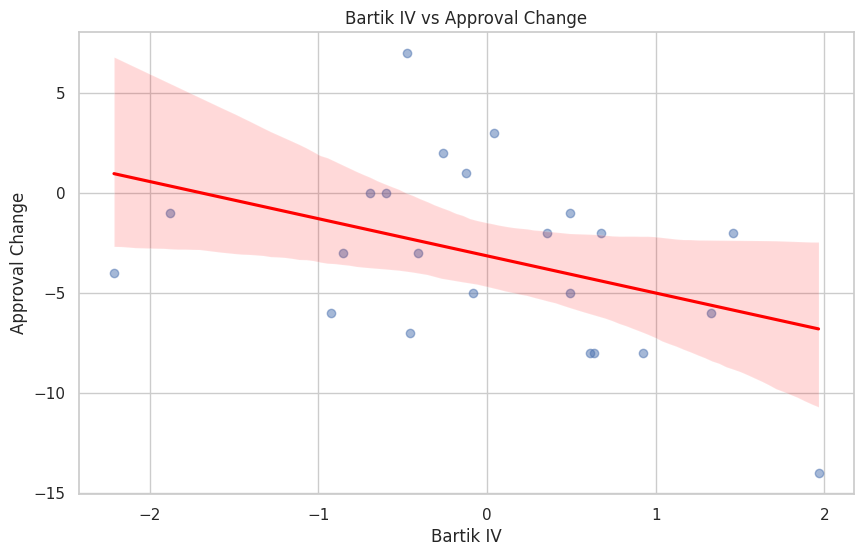

In [301]:
# plot bartik vs approval change with regression line
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.regplot(x='bartik_iv', y='approval_change', data=dataset, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Bartik IV vs Approval Change')
plt.xlabel('Bartik IV')
plt.ylabel('Approval Change')

plt.show()

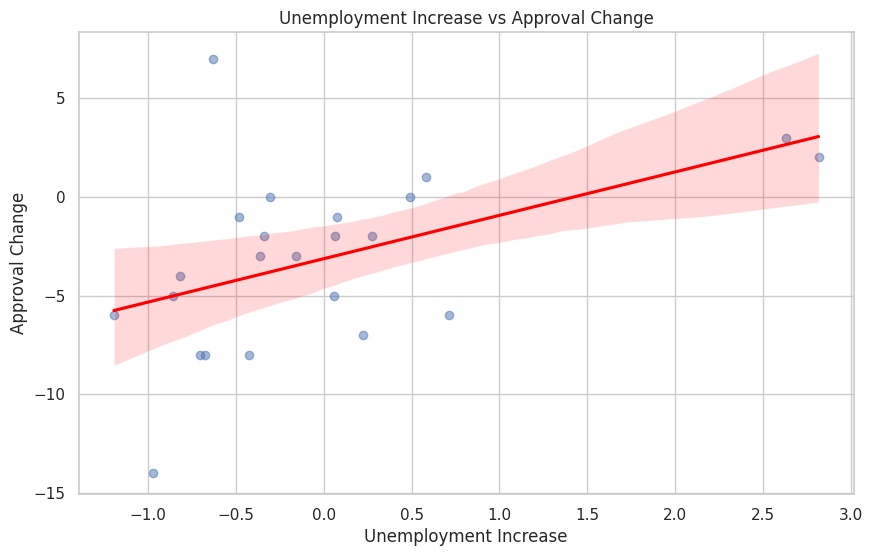

In [305]:
# plot approval change vs unemployment increase with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='unemployment_increase', y='approval_change', data=dataset, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Unemployment Increase vs Approval Change')
plt.xlabel('Unemployment Increase')
plt.ylabel('Approval Change')
plt.show()